In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.4 MB/s eta 0:00:00


In [ ]:

import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

In [ ]:

# Load the MRPC dataset from the GLUE benchmark
dataset = load_dataset('glue', 'mrpc')

# Split the dataset into training, validation, and test sets
train_dataset = dataset['train']
val_dataset = dataset['validation']
test_dataset = dataset['test']


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/3668 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/408 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1725 [00:00<?, ? examples/s]

In [ ]:

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

def encode_examples(dataset):
    inputs = tokenizer(
        dataset['sentence1'],
        dataset['sentence2'],
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='tf'
    )
    # Convert tensors to NumPy arrays
    inputs = {k: v.numpy() for k, v in inputs.items()}

    # Map original label values to the range [0, num_classes - 1]
    labels = np.array(dataset['label'], dtype=np.int32)
    return inputs, labels

# Encode the training, validation, and test sets
train_inputs, train_labels = encode_examples(train_dataset)
val_inputs, val_labels = encode_examples(val_dataset)
test_inputs, test_labels = encode_examples(test_dataset)



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
## Define a custom layer for graph attention
class GraphAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(GraphAttention, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='zeros',
                                 trainable=True)
        self.u = self.add_weight(shape=(self.units, 1),
                                 initializer='glorot_uniform',
                                 trainable=True)

    def call(self, inputs):
        # Compute the attention weights
        h = tf.nn.tanh(tf.matmul(inputs, self.W) + self.b)
        attention_scores = tf.matmul(h, self.u)
        attention_weights = tf.nn.softmax(attention_scores, axis=1)

        # Apply attention weights to inputs
        output = tf.reduce_sum(inputs * attention_weights, axis=1)

        # Ensure the output shape matches the expected shape
        output = tf.expand_dims(output, axis=1)  # Add an extra dimension
        return output



In [ ]:
class HybridModel(tf.keras.Model):
    def __init__(self, num_labels):
        super(HybridModel, self).__init__()
        self.transformer = TFAutoModelForSequenceClassification.from_pretrained('bert-base-uncased')
        self.graph_attention = GraphAttention(units=128) # Increase units
        self.dropout = tf.keras.layers.Dropout(0.2)
        self.batch_norm = tf.keras.layers.BatchNormalization() # Add batch normalization
        self.dense_layer = tf.keras.layers.Dense(128, activation='relu') # Increase units
        self.classifier = tf.keras.layers.Dense(num_labels, activation='softmax')

    def call(self, inputs):
        transformer_output = self.transformer(inputs)[0]
        attention_output = self.graph_attention(transformer_output)
        output = self.dropout(attention_output)
        output = self.batch_norm(output) # Apply batch normalization
        output = self.dense_layer(output)
        output = self.classifier(output)
        return output


In [ ]:
# Initialize the hybrid model
model = HybridModel(num_labels=2)

# Define learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=3e-5,
    decay_steps=1000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Compile the model
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Train the model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(train_inputs, train_labels,
                    validation_data=(val_inputs, val_labels),
                    epochs=10,
                    batch_size=32,
                    callbacks=[early_stopping])


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
115/115 [==============================] - 153s 862ms/step - loss: 0.6689 - accuracy: 0.6944 - val_loss: 0.6640 - val_accuracy: 0.6520
Epoch 2/10
115/115 [==============================] - 89s 772ms/step - loss: 0.6094 - accuracy: 0.8288 - val_loss: 0.5885 - val_accuracy: 0.8309
Epoch 3/10
115/115 [==============================] - 90s 785ms/step - loss: 0.5531 - accuracy: 0.8855 - val_loss: 0.5664 - val_accuracy: 0.8235
Epoch 4/10
115/115 [==============================] - 90s 786ms/step - loss: 0.5092 - accuracy: 0.8964 - val_loss: 0.5279 - val_accuracy: 0.8578
Epoch 5/10
115/115 [==============================] - 90s 787ms/step - loss: 0.4707 - accuracy: 0.9068 - val_loss: 0.5056 - val_accuracy: 0.8775
Epoch 6/10
115/115 [==============================] - 89s 771ms/step - loss: 0.4428 - accuracy: 0.9125 - val_loss: 0.4917 - val_accuracy: 0.8480
Epoch 7/10
115/115 [==============================] - 91s 788ms/step - loss: 0.4127 - accuracy: 0.9138 - val_loss: 0.4624 - val_a

13/13 [==============================] - 4s 269ms/step - loss: 0.4530 - accuracy: 0.8186
Validation Loss: 0.453024297952652, Validation Accuracy: 0.8186274766921997
54/54 [==============================] - 15s 274ms/step - loss: 0.4498 - accuracy: 0.8162
Test Loss: 0.44978833198547363, Test Accuracy: 0.816231906414032
54/54 [==============================] - 23s 269ms/step
Precision: 0.8915094339622641
Recall: 0.8238884045335658
F1 Score: 0.856366107838695
Confusion Matrix:
 [[463 115]
 [202 945]]
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.80      0.74       578
           1       0.89      0.82      0.86      1147

    accuracy                           0.82      1725
   macro avg       0.79      0.81      0.80      1725
weighted avg       0.83      0.82      0.82      1725



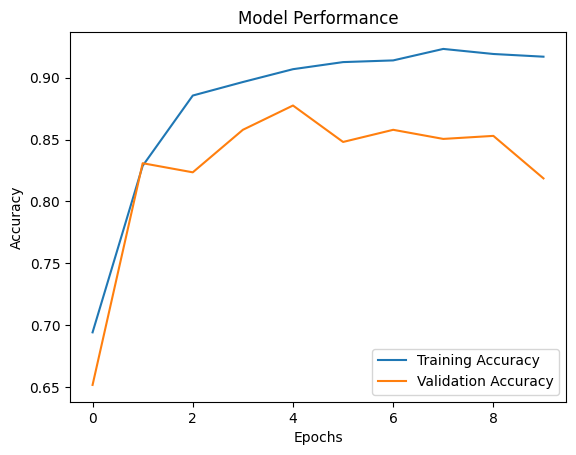

In [ ]:
# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(val_inputs, val_labels)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(test_inputs, test_labels)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Make predictions on the test set
predictions = np.argmax(model.predict(test_inputs), axis=-1)

# Calculate additional evaluation metrics
precision, recall, f1_score, _ = precision_recall_fscore_support(test_labels, predictions, average='binary')
conf_matrix = confusion_matrix(test_labels, predictions)
class_report = classification_report(test_labels, predictions)

# Print additional evaluation metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

# Plotting performance graph
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Performance')
plt.legend()
plt.show()


In [ ]:
class Model(tf.keras.Model):
    def __init__(self, num_labels):
        super(Model, self).__init__()
        self.transformer = TFAutoModelForSequenceClassification.from_pretrained('bert-base-uncased')
        self.dropout = tf.keras.layers.Dropout(0.2)
        self.batch_norm = tf.keras.layers.BatchNormalization() # Add batch normalization
        self.dense_layer = tf.keras.layers.Dense(128, activation='relu') # Increase units
        self.classifier = tf.keras.layers.Dense(num_labels, activation='softmax')

    def call(self, inputs):
        output = self.transformer(inputs)[0]
        output = self.dropout(output)
        output = self.batch_norm(output) # Apply batch normalization
        output = self.dense_layer(output)
        output = self.classifier(output)
        return output


# Initialize the model
model2 = Model(num_labels=2)

# Define learning rate scheduler
lr_schedule2 = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=3e-5,
    decay_steps=1000,
    decay_rate=0.9
)
optimizer2 = tf.keras.optimizers.Adam(learning_rate=lr_schedule2)

# Compile the model
model2.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Train the model with early stopping
early_stopping2 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history2 = model2.fit(train_inputs, train_labels,
                    validation_data=(val_inputs, val_labels),
                    epochs=10,
                    batch_size=32)


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
115/115 [==============================] - 163s 887ms/step - loss: 0.6411 - accuracy: 0.6595 - val_loss: 0.6340 - val_accuracy: 0.6838
Epoch 2/10
115/115 [==============================] - 93s 810ms/step - loss: 0.6321 - accuracy: 0.6745 - val_loss: 0.6251 - val_accuracy: 0.6838
Epoch 3/10
115/115 [==============================] - 93s 809ms/step - loss: 0.6333 - accuracy: 0.6745 - val_loss: 0.6313 - val_accuracy: 0.6838
Epoch 4/10
115/115 [==============================] - 91s 795ms/step - loss: 0.6340 - accuracy: 0.6745 - val_loss: 0.6375 - val_accuracy: 0.6838
Epoch 5/10
115/115 [==============================] - 93s 808ms/step - loss: 0.6331 - accuracy: 0.6745 - val_loss: 0.6382 - val_accuracy: 0.6838
Epoch 6/10
115/115 [==============================] - 93s 807ms/step - loss: 0.6328 - accuracy: 0.6745 - val_loss: 0.6255 - val_accuracy: 0.6838
Epoch 7/10
115/115 [==============================] - 93s 807ms/step - loss: 0.6339 - accuracy: 0.6745 - val_loss: 0.6308 - val_a

13/13 [==============================] - 4s 261ms/step - loss: 0.6271 - accuracy: 0.6838
Validation Loss: 0.6271365880966187, Validation Accuracy: 0.6838235259056091
54/54 [==============================] - 15s 271ms/step - loss: 0.6385 - accuracy: 0.6649
Test Loss: 0.6385027170181274, Test Accuracy: 0.6649275422096252
54/54 [==============================] - 24s 271ms/step
Precision: 0.664927536231884
Recall: 1.0
F1 Score: 0.7987465181058496
Confusion Matrix:
 [[   0  578]
 [   0 1147]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       578
           1       0.66      1.00      0.80      1147

    accuracy                           0.66      1725
   macro avg       0.33      0.50      0.40      1725
weighted avg       0.44      0.66      0.53      1725



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


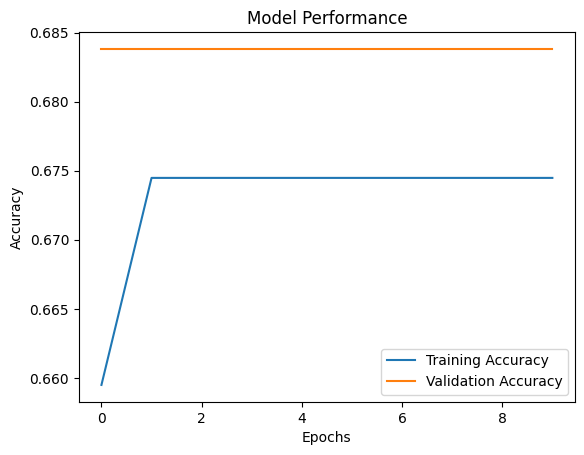

In [ ]:
# Evaluate the model on validation set
val_loss2, val_accuracy2 = model2.evaluate(val_inputs, val_labels)
print(f"Validation Loss: {val_loss2}, Validation Accuracy: {val_accuracy2}")

# Evaluate the model on test set
test_loss2, test_accuracy2 = model2.evaluate(test_inputs, test_labels)
print(f"Test Loss: {test_loss2}, Test Accuracy: {test_accuracy2}")

# Make predictions on the test set
predictions2 = np.argmax(model2.predict(test_inputs), axis=-1)

# Calculate additional evaluation metrics
precision2, recall2, f1_score2, _ = precision_recall_fscore_support(test_labels, predictions2, average='binary')
conf_matrix2 = confusion_matrix(test_labels, predictions2)
class_report2 = classification_report(test_labels, predictions2)

# Print additional evaluation metrics
print("Precision:", precision2)
print("Recall:", recall2)
print("F1 Score:", f1_score2)
print("Confusion Matrix:\n", conf_matrix2)
print("Classification Report:\n", class_report2)

# Plotting performance graph
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Performance')
plt.legend()
plt.show()
